In [43]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [44]:
day = "0809"
name_notebook = day + "-sh_em_1qm_v2.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [45]:
import numpy as np

In [46]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [47]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [48]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [49]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [50]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [51]:
n_aminoacids = len(string_list[0])

In [52]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 4,
    different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [53]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'embedding_weights': (48,), 'block_weights': (600,)}, (20,))

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

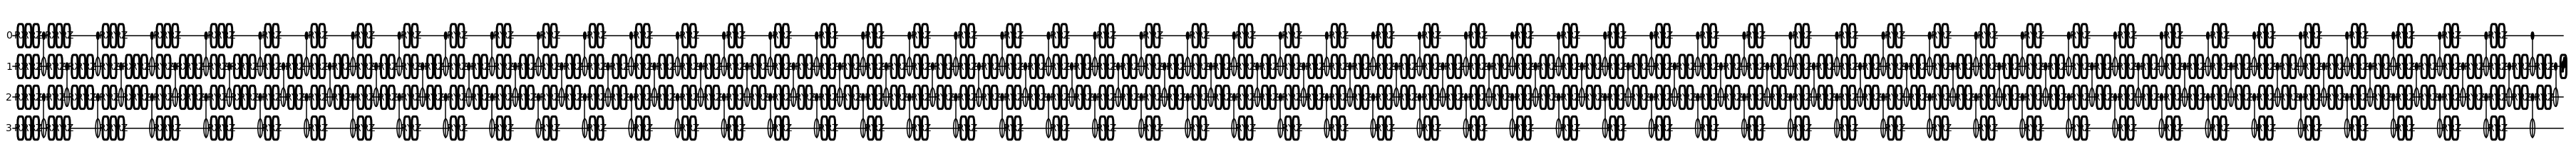

In [54]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [55]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [56]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [57]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [58]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [59]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [60]:
x = model.model[0](input_data[0:2])
print(x, x.shape)

x = model.model[1](x)
print(x, x.shape)

x = model.model[2](x)
print(x)

tensor([[[-0.0238,  0.4056,  0.0652, -0.4255, -0.6631],
         [ 0.8484, -1.5771, -0.3727, -0.3054, -0.2309],
         [ 0.0460, -0.8900,  0.2898,  1.4276, -2.1689],
         [ 0.7685, -0.2820,  0.4186,  1.6165,  1.3516]],

        [[-0.3352,  0.0320, -0.0784, -0.6548, -1.1032],
         [-0.0574, -1.3551,  0.1214, -0.7154,  0.5706],
         [ 2.7486,  0.8973,  0.0929, -0.4102,  1.6967],
         [ 0.0460, -0.8900,  0.2898,  1.4276, -2.1689]]],
       grad_fn=<EmbeddingBackward>) torch.Size([2, 4, 5])
tensor([[-0.0238,  0.8484,  0.0460,  0.7685,  0.4056, -1.5771, -0.8900, -0.2820,
          0.0652, -0.3727,  0.2898,  0.4186, -0.4255, -0.3054,  1.4276,  1.6165,
         -0.6631, -0.2309, -2.1689,  1.3516],
        [-0.3352, -0.0574,  2.7486,  0.0460,  0.0320, -1.3551,  0.8973, -0.8900,
         -0.0784,  0.1214,  0.0929,  0.2898, -0.6548, -0.7154, -0.4102,  1.4276,
         -1.1032,  0.5706,  1.6967, -2.1689]], grad_fn=<SqueezeBackward0>) torch.Size([2, 20])
tensor([[ 0.0435],
      

In [61]:
for i in range(2):
    x = model.model[0](input_data[i])
    print(x, x.shape)

    x = model.model[1](x)
    print(x, x.shape)

    x = model.model[2](x)
    print(i, x)

tensor([[-0.0238,  0.4056,  0.0652, -0.4255, -0.6631],
        [ 0.8484, -1.5771, -0.3727, -0.3054, -0.2309],
        [ 0.0460, -0.8900,  0.2898,  1.4276, -2.1689],
        [ 0.7685, -0.2820,  0.4186,  1.6165,  1.3516]],
       grad_fn=<EmbeddingBackward>) torch.Size([4, 5])
tensor([-0.0238,  0.8484,  0.0460,  0.7685,  0.4056, -1.5771, -0.8900, -0.2820,
         0.0652, -0.3727,  0.2898,  0.4186, -0.4255, -0.3054,  1.4276,  1.6165,
        -0.6631, -0.2309, -2.1689,  1.3516], grad_fn=<SqueezeBackward0>) torch.Size([20])
0 tensor([0.0435], grad_fn=<CatBackward>)
tensor([[-0.3352,  0.0320, -0.0784, -0.6548, -1.1032],
        [-0.0574, -1.3551,  0.1214, -0.7154,  0.5706],
        [ 2.7486,  0.8973,  0.0929, -0.4102,  1.6967],
        [ 0.0460, -0.8900,  0.2898,  1.4276, -2.1689]],
       grad_fn=<EmbeddingBackward>) torch.Size([4, 5])
tensor([-0.3352, -0.0574,  2.7486,  0.0460,  0.0320, -1.3551,  0.8973, -0.8900,
        -0.0784,  0.1214,  0.0929,  0.2898, -0.6548, -0.7154, -0.4102,  1.42

In [62]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.8636],
        [-0.9038]], grad_fn=<AddmmBackward>)
tensor([-0.9038], grad_fn=<AddBackward0>)


In [63]:
model.keep_track_params=True,

In [74]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.1},
    num_epochs = 10,                
    batch_size = 32,
    initialization_options = [
        {
            'type': 'normal_',
            'layer': 2, 
            'name': 'bias',
            'options': {'mean': 100, 'std': 10},
        },{
            'type': 'normal_',
            'layer': 2,
            'name': 'weight',
            'options': {'mean': 200, 'std': 10},
        },
    ]
)

Epoch [0/10], Loss: 0.9992, Loss validation: 0.9992
	 Validation string, 	 i: 0; 	 prediction: -6.6510, 	 target: -78.0800, 	 loss: 0.9148
	 Validation string, 	 i: 1; 	 prediction: -3.0883, 	 target: -101.1460, 	 loss: 0.9695
	 Validation string, 	 i: 2; 	 prediction: -4.1433, 	 target: -74.1160, 	 loss: 0.9441
Epoch [1/10], Loss: 0.9147, Loss validation: 0.7990, Time remaining: ~0.0h 18.0m 35s
	 Validation string, 	 i: 0; 	 prediction: -18.9313, 	 target: -78.0800, 	 loss: 0.7575
	 Validation string, 	 i: 1; 	 prediction: -18.1673, 	 target: -101.1460, 	 loss: 0.8204
	 Validation string, 	 i: 2; 	 prediction: -19.8057, 	 target: -74.1160, 	 loss: 0.7328
Epoch [2/10], Loss: 0.7617, Loss validation: 0.6123, Time remaining: ~0.0h 15.0m 31s
	 Validation string, 	 i: 0; 	 prediction: -32.0157, 	 target: -78.0800, 	 loss: 0.5900
	 Validation string, 	 i: 1; 	 prediction: -32.5297, 	 target: -101.1460, 	 loss: 0.6784
	 Validation string, 	 i: 2; 	 prediction: -31.3237, 	 target: -74.1160, 	

In [65]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0809/txts/0809-sh_em_1qm_v2_model_str_3.txt


Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_batches_3.png


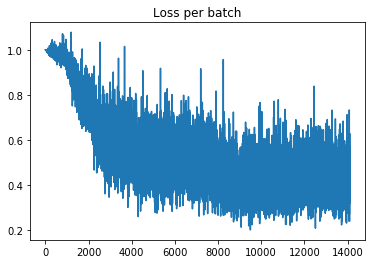

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_3.png


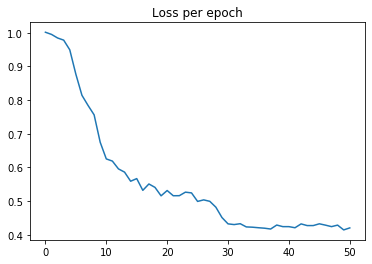

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_validation_3.png


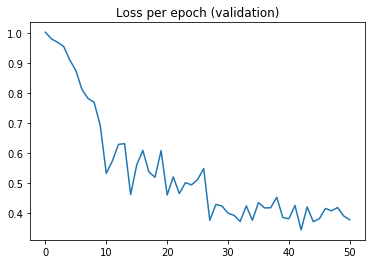

In [66]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_0.weight_None_3.png


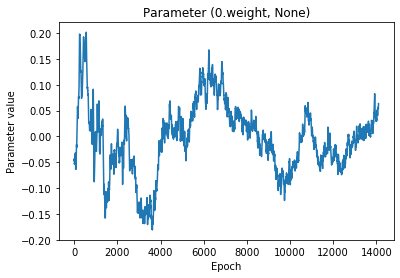

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.embedding_weights_None_3.png


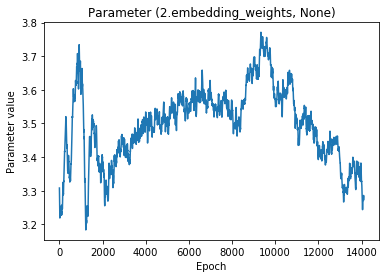

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.block_weights_None_3.png


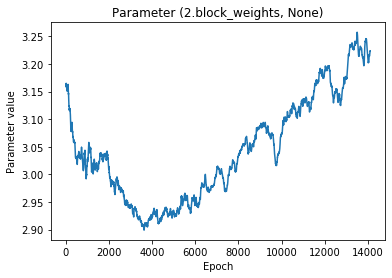

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.weight_None_3.png


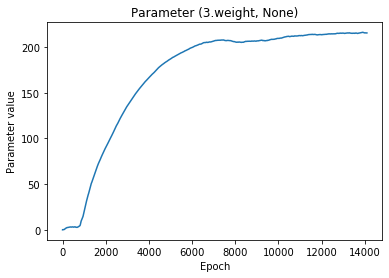

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.bias_None_3.png


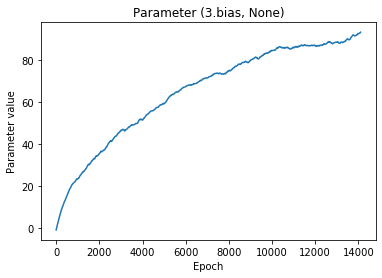

In [67]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [68]:
# model.plot_parameter(layer='7.weights', index=50)

In [69]:
model.load_state_dict(version=1)

Model loaded from peptide-QML/checkpoints/0809/models/0809-sh_em_1qm_v2_1.pth


In [70]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0809/models/0809-sh_em_1qm_v2_3.pth


Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_validation_3.png


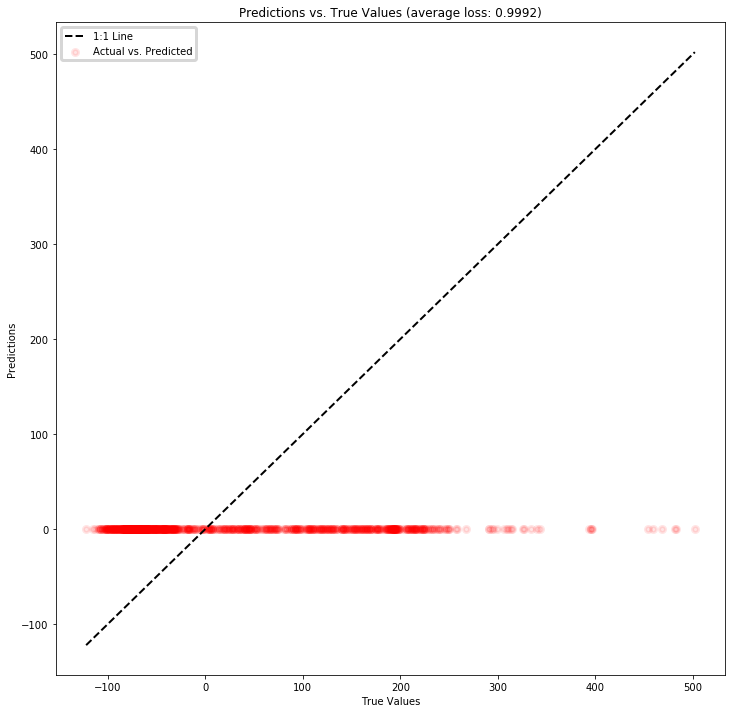

In [71]:
model.plot_validation(save=True, fig_size=(12,12))

In [72]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -78.0800, 	 prediction: -0.0354, 	 loss: 0.9995
i: 1, 		 target: -42.4080, 	 prediction: -0.0652, 	 loss: 0.9985
i: 2, 		 target: 220.1500, 	 prediction: 0.1991, 	 loss: 0.9991
i: 3, 		 target: -69.5500, 	 prediction: -0.0602, 	 loss: 0.9991
i: 4, 		 target: -101.6020, 	 prediction: -0.0641, 	 loss: 0.9994
i: 5, 		 target: -95.9410, 	 prediction: -0.0613, 	 loss: 0.9994
i: 6, 		 target: -83.9420, 	 prediction: -0.0430, 	 loss: 0.9995
i: 7, 		 target: 174.9550, 	 prediction: 0.1167, 	 loss: 0.9993
i: 8, 		 target: 453.8340, 	 prediction: 0.3246, 	 loss: 0.9993
i: 9, 		 target: 213.2580, 	 prediction: 0.1602, 	 loss: 0.9992
i: 10, 		 target: -101.1460, 	 prediction: -0.0784, 	 loss: 0.9992
i: 11, 		 target: -73.6810, 	 prediction: -0.0482, 	 loss: 0.9993
i: 12, 		 target: 51.8760, 	 prediction: -0.0165, 	 loss: 1.0003
i: 13, 		 target: 118.4490, 	 prediction: 0.0661, 	 loss: 0.9994
i: 14, 		 target: -97.8780, 	 prediction: -0.0479, 	 loss: 0.9995
i: 15, 		 target: 34.715

In [73]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 5e76f65c] data trained model
 14 files changed, 1042 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0809/models/0809-sh_em_1qm_v2_3.pth
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_batches_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_validation_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_0.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.block_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.embedding_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.bias_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_validation_2.png
 create mode 100644 checkpoints/0809/plots